In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

In [2]:
df_wine = pd.read_csv('/kaggle/input/datasets-rpaa-p7/wine.csv')
df_clusters = pd.read_csv('/kaggle/input/datasets-rpaa-p7/clusters.csv')
np.random.seed(42)

# I
--- 
Usando K-means y el archivo wine.csv realiza los siguientes ejercicios:
1. Para $k = 1, \dotsc, 10$. Calcula el WCSS para cada k y graficalos.
1. Justifica qué valor de $k$ sería el más óptimo
1. Obtén las diferentes clases de vinos.

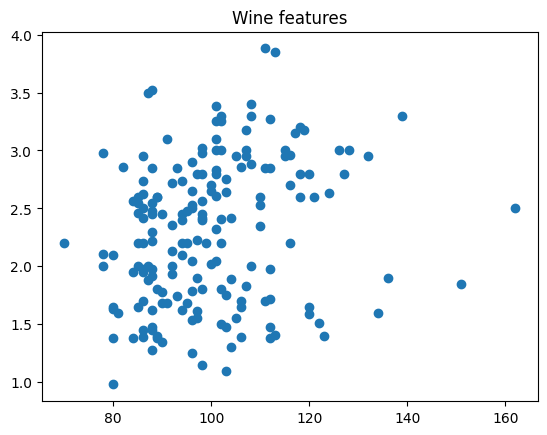

In [4]:
X_wine = df_wine.iloc[:, [4,5]].values
plt.scatter(X_wine[:, 0], X_wine[:, 1])
plt.title('Wine features')
plt.show()

In [5]:
K = 10
wcss = []
silhouette_scores = []

for i in range(2, K + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
        kmeans.fit(X_wine)
        wcss.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(X_wine, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

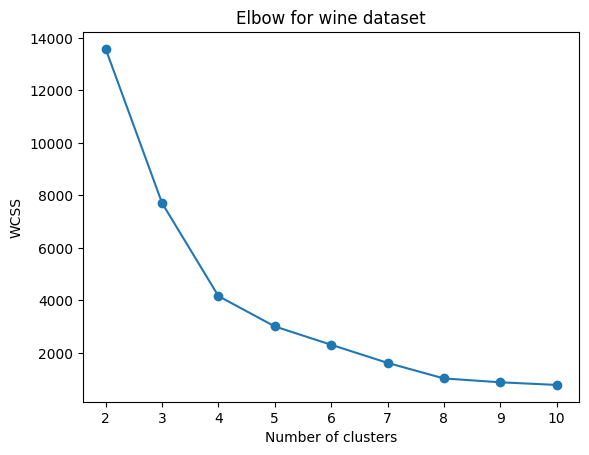

In [6]:
plt.plot(range(2,K+1), wcss)
plt.scatter(range(2,K+1), wcss)
plt.title('Elbow for wine dataset')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

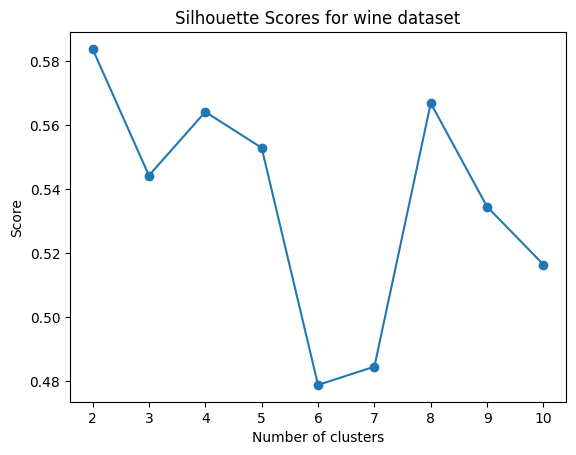

In [7]:
plt.plot(range(2,K+1), silhouette_scores)
plt.scatter(range(2,K+1), silhouette_scores)
plt.title('Silhouette Scores for wine dataset')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

El valor más óptimo corresponde al número de clústers 4, dado que es el punto donde la gráfica de WCSS muestra un cambio 
significativo decreciente.

In [101]:
def plot_clusters(X, y=None, **kwargs):
    point_size = kwargs.get('s', 50)
    plotter = kwargs.get('ax', plt)
    plotter.scatter(X[:,0], X[:,1], c=y, s=point_size)
    centroids = kwargs.get('plot_centroids', True)
    
    if centroids:
        cent_coords = kwargs.get('centroids', None)
        if cent_coords is not None:
            plotter.scatter(cent_coords[:, 0], cent_coords[:, 1],
                        s=point_size*2, c='red', label='centroids')
    if kwargs.get('legend', False): plt.legend()
    if kwargs.get('show', False): plt.show()

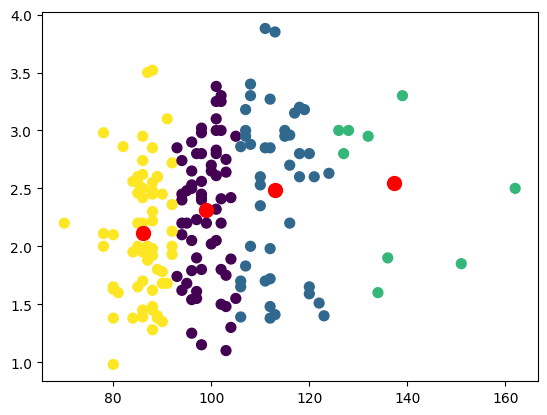

In [105]:
N_CLUSTERS = 4
kmeans_c = KMeans(n_clusters=N_CLUSTERS, init='k-means++', 
                  n_init='auto', random_state=42)
y_pred = kmeans_c.fit_predict(X_wine)
cmap = plt.get_cmap('plasma', N_CLUSTERS)

plot_clusters(X_wine, y_pred, plot_centroids=True, 
              centroids=kmeans_c.cluster_centers_,
              legend=True, show=True)

# II
Usando el archivo `clusters.csv` realizaa lo siguiente:
1. Utiliza Hierarchical clustering, K-Means, DBSCAN y GaussianMixture para obtener los diferentes clusters.
1. Utiliza al menos tres formas de evaluar los resultados de los algoritmos utilizados.
1. Prueba diferentes hiperparámetros en cada uno de los modelos y reporta aquellos que produzcan los mejores resutados.
1. ¿Cuál es el número óptimo de clusters para este conjunto de datos? Justifica tu respuesta.
1. Compara los resultados entre los diferentes algoritmos. ¿Cuál es el mejor algoritmo para clasificar este conjunto de datos?

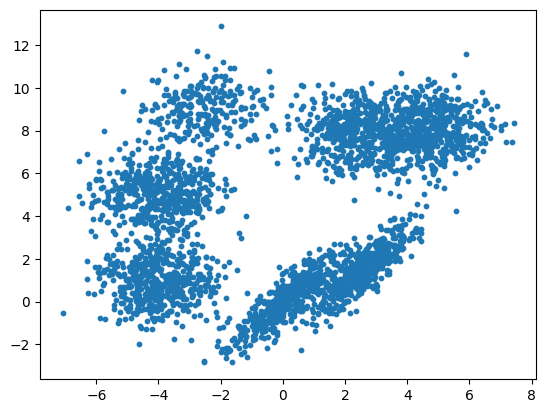

In [106]:
X_clusters = df_clusters.values
plot_clusters(X_clusters, s=10)

In [48]:
def cluster_strat(data, strat='kmeans', **kwargs):
    match strat:
        case 'hierarchy':
            n_clusters = kwargs.get('n_clusters', 5)
            linkage = kwargs.get('linkage', 'ward')
            algo = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', 
                                           linkage=linkage).fit(data)
            
        case 'dbscan':
            epsilon = kwargs.get('epsilon', 0.25)
            algo = DBSCAN(eps=epsilon, min_samples=5 ,n_jobs=-1).fit(data)
            
        case 'gmm':
            n_components = kwargs.get('n_components', 5)
            algo = GaussianMixture(n_components=n_components, n_init=7, 
                                   random_state=42).fit(data)
            
        case _:
            n_clusters = kwargs.get('n_clusters', 5)
            algo = KMeans(n_clusters=n_clusters, init='k-means++',
                          random_state=42, n_init='auto').fit(data)
            
    return algo

### Hierarchical

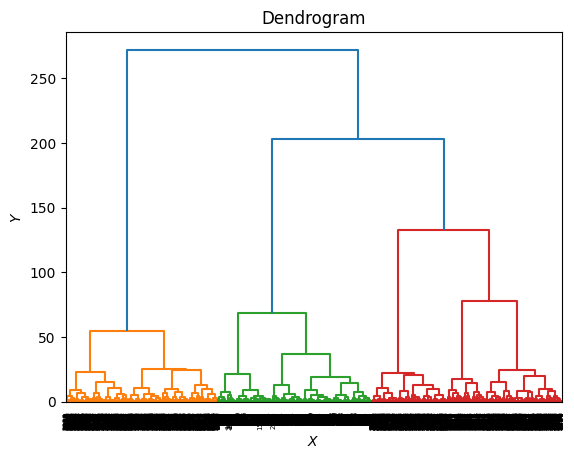

In [25]:
dendrogram = sch.dendrogram(sch.linkage(X_clusters, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.show()

Del dendograma anterior, podemos ver que un buen hiperparámetro para agrupamiento jerárquico es utilizar cinco clústers. Dado que para este utilizamos el método `ward`, usaremos los mismos hiperparámetros en el algoritmo.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


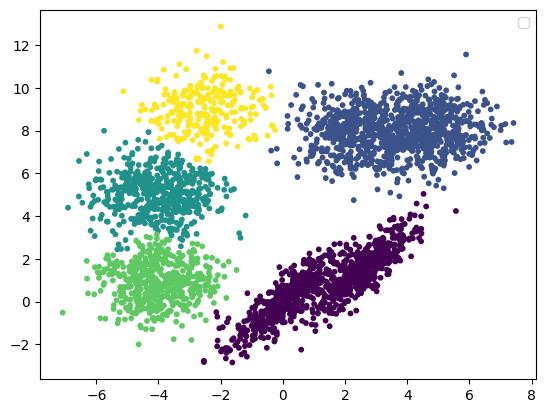

In [53]:
hc = cluster_strat(X_clusters, strat='hierarchy', n_clusters=5, linkage='ward')
plot_clusters(X_clusters, hc.labels_, s=10)

### KMeans

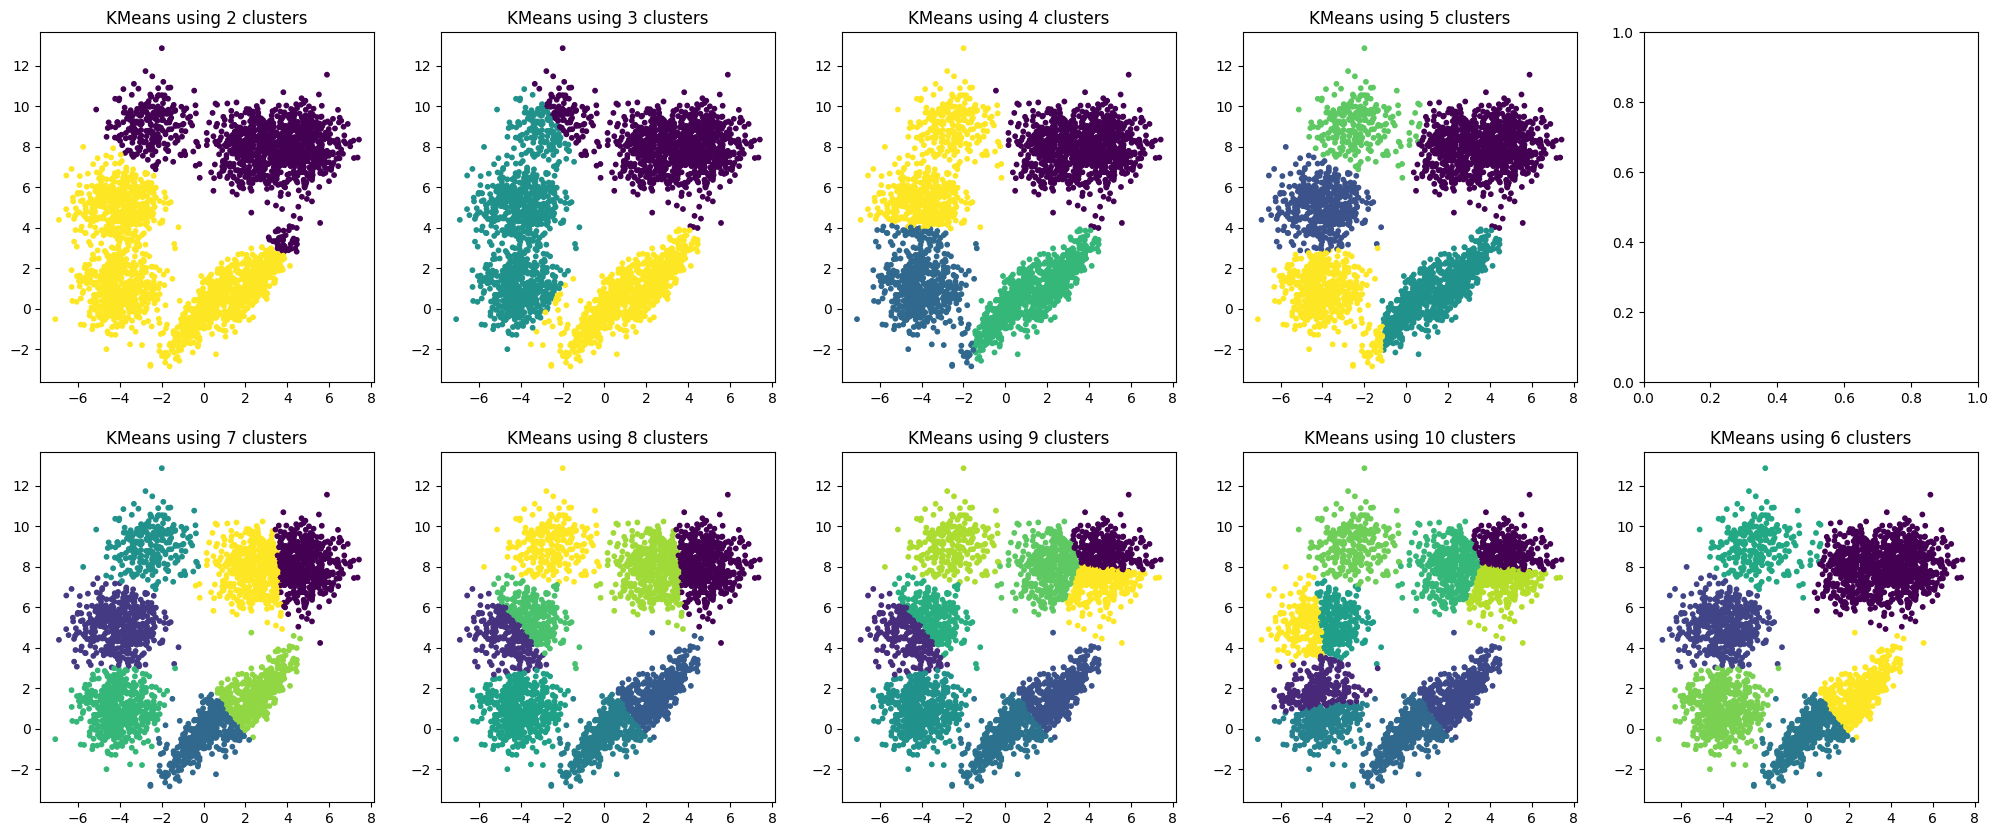

In [111]:
N_ROWS = 2
N_COLS = 5
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(25,10))

for col_idx, i in enumerate(range(2, 11)):
    plot_row = 0 if i <= 5 else 1
    kmean = cluster_strat(X_clusters, n_clusters=i)
    axs[plot_row, col_idx % 5].set_title(f"KMeans using {i} clusters")
    plot_clusters(X_clusters, kmean.labels_, s=10, ax=axs[plot_row, col_idx % 5])

Una vez más, notamos que con cinco clusters tenemos una agrupación relativamente adecuada, mientras que para números más grandes 
o más pequeños a este las agrupaciones son erráticas.

### DBSCAN

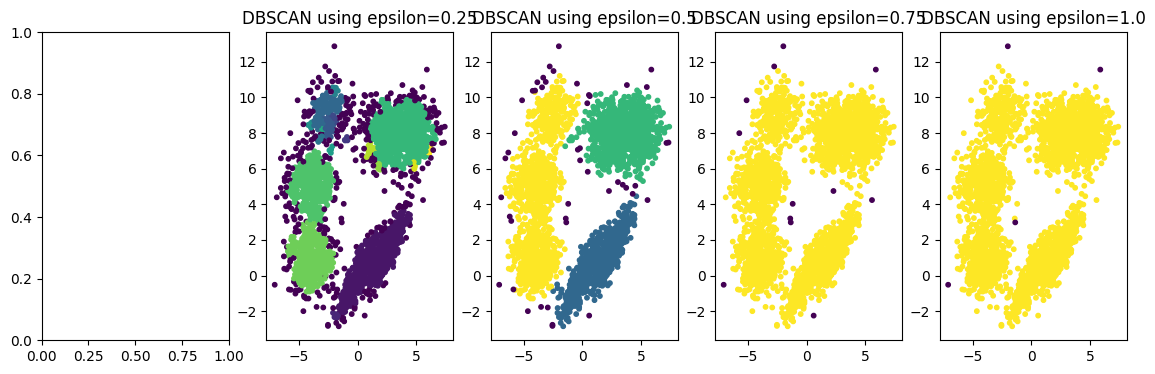

In [119]:
N_ROWS = 1
N_COLS = 5
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(14,4))

for col_idx, i in enumerate(np.linspace(0, 1, 5)):
    if i == 0.: continue
    dbsc = cluster_strat(X_clusters, strat='dbscan', epsilon=i)
    axs[col_idx % 5].set_title(f"DBSCAN using epsilon={i}")
    plot_clusters(X_clusters, dbsc.labels_, s=10, ax=axs[col_idx % 5])

### Gaussian Mixture

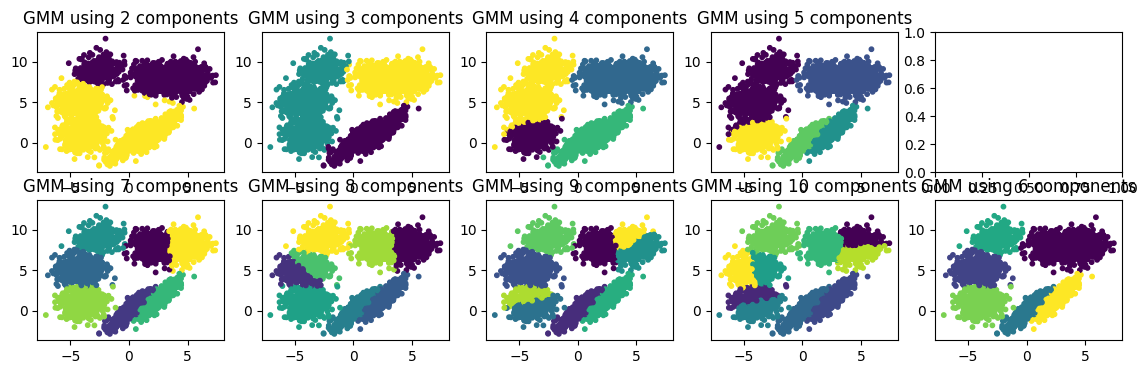

In [123]:
N_ROWS = 2
N_COLS = 5
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(14,4))

for col_idx, i in enumerate(range(2,11)):
    if i == 0.: continue
    plot_row = 0 if i <= 5 else 1
    gmm = cluster_strat(X_clusters, strat='gmm', n_components=i)
    axs[plot_row, col_idx % 5].set_title(f"GMM using {i} components")
    plot_clusters(X_clusters, gmm.predict(X_clusters), s=10, ax=axs[plot_row, col_idx % 5])